- kaggle notebook P100으로 finetuning 진행
- base model : DETR
    - https://huggingface.co/facebook/detr-resnet-50

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


In [ ]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

In [3]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__, 
    "; supervision:", supervision.__version__, 
    "; transformers:", transformers.__version__, 
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  2.1 ; cuda:  2.1.2
roboflow: 1.1.36 ; supervision: 0.3.0 ; transformers: 4.42.3 ; pytorch_lightning: 2.3.3


In [ ]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

In [5]:
ROBOFLOW_API_KEY = '#################'

In [6]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from roboflow import Roboflow
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("readmegenerator").project("powerpoint-detector")
dataset = project.version(1).download("coco")

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


/kaggle/working/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to powerpoint-detector-1 in coco:: 100%|██████████| 1353/1353 [00:00<00:00, 6288.89it/s]


In [7]:
dataset.location

'/kaggle/working/datasets/powerpoint-detector-1'

In [ ]:
pip install -q pycocotools

In [9]:
import os
import torchvision

# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset.location, "train")
VAL_DIRECTORY = os.path.join(dataset.location, "valid")
TEST_DIRECTORY = os.path.join(dataset.location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY, 
    image_processor=image_processor, 
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY, 
    image_processor=image_processor, 
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY, 
    image_processor=image_processor, 
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 1191
Number of validation examples: 99
Number of test examples: 55


Image #75


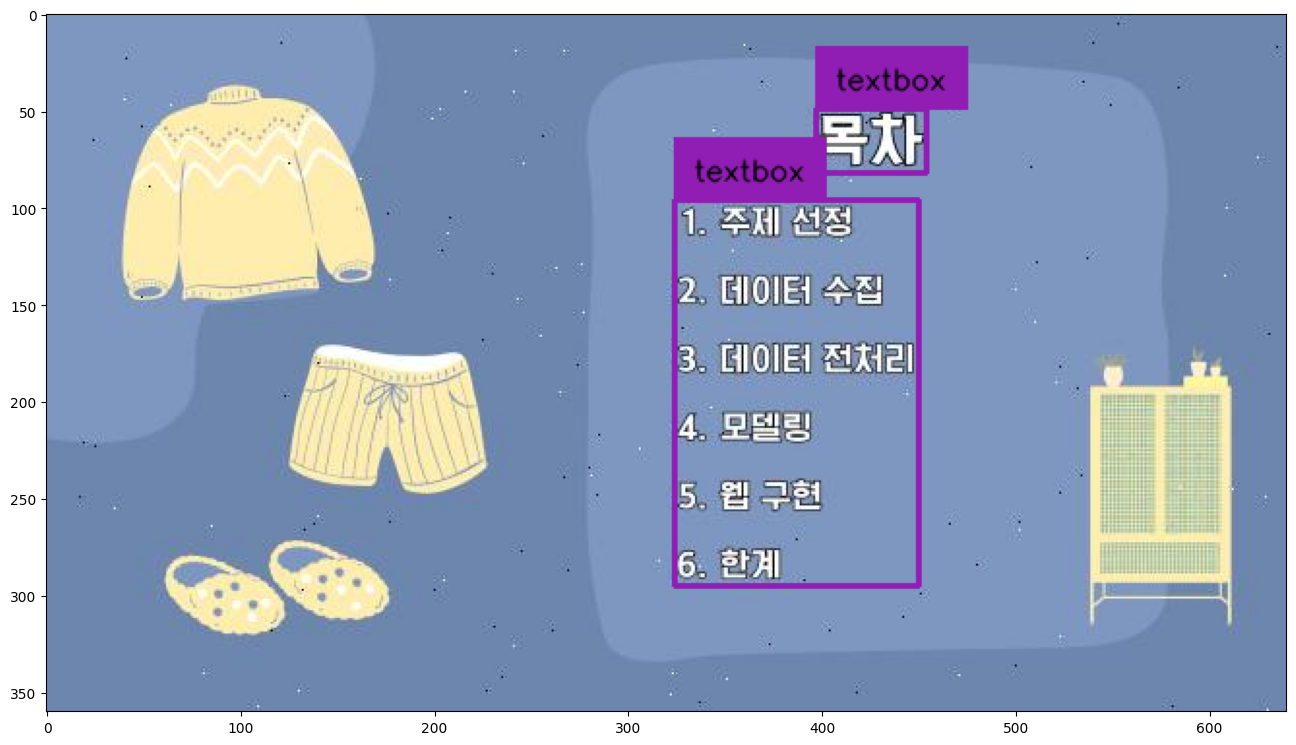

In [10]:
import random
import cv2
import numpy as np
import supervision as sv

# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image, (16, 16))

In [11]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible 
    # to directly batch together images. Hence they pad the images to the biggest 
    # resolution in a given batch, and create a corresponding binary pixel_mask 
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

In [12]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT, 
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

In [ ]:
from pytorch_lightning import Trainer

%cd {HOME}

# settings
MAX_EPOCHS = 50

# pytorch_lightning < 2.0.0
# trainer = Trainer(gpus=1, max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

# pytorch_lightning >= 2.0.0
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)